In [1]:
import os

import contextily as cx
from IPython.display import display
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from src import largest_strongly_connected_component
from run import filepath_network, filepath_un_locode_cleaned, filepath_ships_classification, filepath_portcalls_processed

# Mobility network

In [2]:
G = nx.read_gpickle(filepath_network)
Gc = largest_strongly_connected_component(G)
un_locode = pd.read_pickle(filepath_un_locode_cleaned)

## Figure
### Obtain UNLOCODE

In [3]:
def get_strength(x):
    return [Gc.degree(node) for node in x.index]

nodes = (
    un_locode
    .drop_duplicates(subset='label')
    .set_index('label')
    .loc[lambda x: x.index.isin(Gc)]
    .assign(strength=get_strength)
    .loc[lambda x: x.strength > 10]
)
nodes

,x,y,strength
label,,,
BEANR,4.25,51.13,10405
BEBON,4.14,51.06,28
BEBGS,3.14,51.13,812
BEGNK,5.30,50.58,44
BEGNE,3.43,51.03,2821
...,...,...,...
SEVST,16.33,59.37,548
SEVVK,16.38,57.45,48
SEVBY,18.18,57.38,38


### Select edges with known location

In [4]:
def select_only_edges_with_location(x):
    values = nodes.index
    return x['source'].isin(values) & x['target'].isin(values)
    
selected_edges = (
    nx.to_pandas_edgelist(Gc)
    .loc[select_only_edges_with_location]
    .value_counts()
    .reset_index()
    .rename(columns={0:'weight'})
)
selected_edges

,source,target,weight
0,GBLRP,GBBEL,3955
1,GBBEL,GBLRP,3954
2,FRBON,ITSTE,3101
3,ITSTE,FRBON,3099
4,FRCQF,FRCQF,1902
...,...,...,...
19038,NOARH,NOEKF,1
19039,ESLPA,FRBOD,1
19040,DEWVN,SEMMA,1
19041,GBLIV,ESLCG,1


### Plot

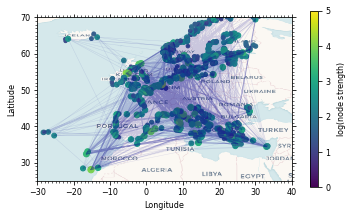

In [5]:
rasterized = False

cmap = cm.get_cmap('viridis')
colors = [cmap(i/5, alpha=i/5) for i in nodes.strength]

xs_strong = list()
ys_strong = list()
xs_weak = list()
ys_weak = list()
for edge in selected_edges.itertuples():
    source_location = nodes.loc[edge.source]
    target_location = nodes.loc[edge.target]
    if edge.weight > 100:
        xs_strong.append((source_location.x, target_location.x))
        ys_strong.append((source_location.y, target_location.y))
    elif edge.weight > 10:
        xs_weak.append((source_location.x, target_location.x))
        ys_weak.append((source_location.y, target_location.y))

with plt.rc_context({'font.size': 8}):
    fig, ax = plt.subplots(figsize=(4.82,3.21), constrained_layout=True)
    ax.plot(xs_strong, ys_strong, color='darkblue', alpha=.2, lw=1, rasterized=rasterized)
    ax.plot(xs_weak, ys_weak, color='darkblue', alpha=.1, lw=.5, rasterized=rasterized)
    ax.scatter(x=nodes.x, y=nodes.y, c=np.log10(nodes.strength), s=np.log10(nodes.strength)*10, cmap='viridis', norm=Normalize(0, 5), alpha=1)
    fig.colorbar(cm.ScalarMappable(norm=Normalize(0, 5), cmap='viridis'), ax=ax, shrink=0.80, label=r'$\log(\mathrm{node}\ \mathrm{strength})$')
    ax.xaxis.set_ticks_position('both')
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xlim(-30, 40)
    ax.set_ylim(25, 70)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    cx.add_basemap(ax, crs='WGS84', zoom=3, interpolation='none', source=cx.providers.CartoDB.Voyager, attribution=False)

    fig.savefig('fig/network.pdf')

## Stats
### Calculate distance distribution

In [6]:
!printf '%s\n' 'load_undirected cache/network.edges' 'dist_distri' > "cache/input.txt"
nx.write_edgelist(nx.convert_node_labels_to_integers(nx.Graph(Gc)), 'cache/network.edges', data=False)
! /data/bruingjde/teexgraph/teexgraph < cache/input.txt > cache/output.txt
output_teexgraph = pd.read_csv('cache/output.txt', sep='\t', names=['distance', 'counts'])
os.remove('cache/network.edges')
os.remove('cache/input.txt')
os.remove('cache/output.txt')
output_teexgraph

*** Welcome to teexGraph ***
- Use standard input (cin) to give commands
- Read standard output (cout) to catch the result
- Observe standard log (clog) and (cerr) for status and error messages
- Graphs up to MAXN = 10000000 nodes are accepted
Input a command: Loading an undirected graph. Enter filename: 
Loading graph from cache/network.edges ...
- 28638 edges added (m = 28638) in total
- 0 edges skipped
- 612 self-edges added

Sorting edge list...
Sorting done.
Loading done.

Making graph undirected (m = 28638)...
Sorting edge list...
Sorting done.
  Verify that the graph is actually undirected.
Undirected-making done (m = 56664).
Loading file succeeded.
WCC computed.

> Computing distance distribution (based on a 100% sample of 1445 nodes) with 256 CPUs...
        0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0  0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0%   0% 0% 0% 0% 0% 0% 0% 0%  0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0% 0%0%0%0% 0% 0% 0% 

,distance,counts
0,0,1445
1,1,56052
2,2,860418
3,3,963380
4,4,194988
5,5,11620
6,6,122


### Missing ports

In [7]:
ships_classification = np.load(filepath_ships_classification)
portcalls_processed = pd.read_pickle(filepath_portcalls_processed)
portcalls_classification = portcalls_processed.loc[lambda x: x['ship'].isin(ships_classification)]
ports_ml = portcalls_classification['port'].unique()
observed = [port in Gc for port in ports_ml]
result = np.bincount(observed)
message = "Ports in ML observed in weakly connected component of cargo ship network"
print(f"{message}: {result} (no/yes)")
print(f"{result/len(observed)}")

Ports in ML observed in weakly connected component of cargo ship network: [ 525 1427] (no/yes)
[0.26895492 0.73104508]


### Summary

In [8]:
{
    'number of nodes': G.number_of_nodes(),
    'number of nodes in GC': Gc.number_of_nodes(),
    'number of edges': nx.Graph(G).number_of_edges(),
    'fraction of edges in GC': nx.Graph(Gc).number_of_edges(),
    'density': nx.density(nx.Graph(Gc)),
    'diameter': output_teexgraph['distance'].max(),
    'average distance': np.average(output_teexgraph['distance'], weights=output_teexgraph['counts']),
    'clustering coefficient': nx.average_clustering(nx.Graph(Gc)),
    'degree assortativity': nx.degree_assortativity_coefficient(nx.Graph(Gc)),
    'strength assortativity': nx.degree_assortativity_coefficient(Gc)
}

{'number of nodes': 1459,
 'number of nodes in GC': 1445,
 'number of edges': 28653,
 'fraction of edges in GC': 28638,
 'density': 0.027449702383805077,
 'diameter': 6,
 'average distance': 2.636851570263766,
 'clustering coefficient': 0.4756258478731693,
 'degree assortativity': -0.07604151737724668,
 'strength assortativity': 0.3521541970827181}

In [9]:
sorted(list(G.degree(weight='weight')), key=lambda x: x[1], reverse=True)

[('DEPUT', 25312),
 ('NLRTM', 23592),
 ('ESALG', 16191),
 ('GBBEL', 13310),
 ('GBPME', 11622),
 ('BEANR', 10405),
 ('ESLPA', 9961),
 ('DEHAM', 8383),
 ('ESBCN', 8261),
 ('ITGOA', 8025),
 ('GBLRP', 7972),
 ('FRBON', 7135),
 ('ESVLC', 6909),
 ('ESIBZ', 6795),
 ('ITSTE', 6697),
 ('ESTRF', 6628),
 ('ITLIV', 5901),
 ('GBIMM', 5866),
 ('GRRAF', 5653),
 ('GBLON', 5544),
 ('DEBRV', 5387),
 ('GBABD', 5288),
 ('GIGIB', 5233),
 ('ITPMO', 5195),
 ('NLAMS', 5016),
 ('ITCVV', 4998),
 ('GRTSO', 4780),
 ('SEGOT', 4651),
 ('GRIGO', 4651),
 ('ESSCT', 4572),
 ('ESPMI', 4566),
 ('FRCQF', 4559),
 ('GRKER', 4354),
 ('GBSOU', 4278),
 ('GRPIR', 4055),
 ('ITNAP', 3939),
 ('GBPHD', 3912),
 ('ITOLB', 3436),
 ('GBHUL', 3429),
 ('ITAOI', 3409),
 ('ITBRI', 3274),
 ('ITCTA', 3270),
 ('GBBRK', 3068),
 ('FRFOS', 3036),
 ('FRMRS', 2981),
 ('ESCBS', 2954),
 ('ITRAN', 2929),
 ('LTKLJ', 2851),
 ('GBHRW', 2850),
 ('BEGNE', 2821),
 ('FRLEH', 2773),
 ('ESMOT', 2756),
 ('LVRIX', 2690),
 ('BEZEE', 2677),
 ('GBLIV', 2676),
 ('N